In [1]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from bisect import bisect

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 7.0]
mpl.rcParams['figure.dpi'] = 100

In [3]:
import ground_truth as GT
import utils

In [4]:
# hyperparameters

seed = random.randint(1, 1000)                              # random seed

# GRAPH PARAMETERS
N = 10000                                                    # synthetic graph size

# CLASSIFIER PARAMETERS
ratio = 0.333                                               # data splitting ratio is 1/3
quality_class_intervals = [0, 0.25, 0.50, 0.75, 1.001]      # quality class intervals
quality_class_labels = [0, 1, 2, 3]                         # quality class labels
quality_class_names = ['exelent', 'good', 'ok', 'poor']     # quality classes names

# Step 1
## Graph generation / importing


In [5]:
# graph generation with LFR

# creating a ground truth graph
G, Comp_G = GT.LFR(n=N)

# df from graph
ground_truth_df = utils.convert_nx_to_dataframe(G, Comp_G)

# split node pairs with edge existing (1) and non-existing (0)
ground_truth_df0 = ground_truth_df[ground_truth_df['goal'] == 0]
ground_truth_df1 = ground_truth_df[ground_truth_df['goal'] == 1]

n = np.min([len(ground_truth_df0), len(ground_truth_df1)])  # number of sampled edges/non-eges

# sampling n edges and non-edges
ground_truth_df = pd.concat([
    ground_truth_df0.sample(int(n/2)), 
    ground_truth_df1.sample(int(n/2))
])

ground_truth_df0 = ground_truth_df[ground_truth_df['goal'] == 0]
ground_truth_df1 = ground_truth_df[ground_truth_df['goal'] == 1]

ground_truth_df.head(5)

,node1,node2,goal
33594870,4274,8764,0
5550929,571,7059,0
44742595,6764,7167,0
7688978,801,4058,0
5099980,523,9579,0


In [6]:
ground_truth_df['goal'].value_counts()

1    10428
0    10428
Name: goal, dtype: int64

# Step 2
## Feature calculation

In [7]:
feature_names = ['RAI', 'JC', 'AAI', 'PA']

In [8]:
# dataframe with features
features_df = ground_truth_df[['node1', 'node2']]

features_df['RAI'] = features_df.apply(
    lambda row: list(nx.resource_allocation_index(G, [(row['node1'], row['node2'])]))[0][2],
    axis=1
)

features_df['JC'] = features_df.apply(
    lambda row: list(nx.jaccard_coefficient(G, [(row['node1'], row['node2'])]))[0][2],
    axis=1
)

features_df['AAI'] = features_df.apply(
    lambda row: list(nx.adamic_adar_index(G, [(row['node1'], row['node2'])]))[0][2],
    axis=1
)

features_df['PA'] = features_df.apply(
    lambda row: list(nx.preferential_attachment(G, [(row['node1'], row['node2'])]))[0][2],
    axis=1
)

# normalizing
for column_name in ['PA']:
    features_df[column_name] -= features_df[column_name].min()
    features_df[column_name] /= features_df[column_name].max()

features_df.head(5)

,node1,node2,RAI,JC,AAI,PA
33594870,4274,8764,0.0,0.0,0.0,0.011107
5550929,571,7059,0.0,0.0,0.0,0.005183
44742595,6764,7167,0.0,0.0,0.0,0.001481
7688978,801,4058,0.0,0.0,0.0,0.006664
5099980,523,9579,0.0,0.0,0.0,0.004443


# Step 3
## Splitting the data

We split the data in the following way:
* 1/3 is used to train a link prediction model
* 1/3 is used to test the link prediction model. Here we also calculate the error and use this data to train quality classifier
* 1/3 is used to evaluate the clasifier

In [9]:
link_prediction_train = pd.concat([
    ground_truth_df0.sample(int(len(ground_truth_df0) * ratio)), 
    ground_truth_df1.sample(int(len(ground_truth_df1) * ratio))
])

remainder = pd.concat([ground_truth_df, link_prediction_train, link_prediction_train]).drop_duplicates(keep=False)

link_prediction_test = pd.concat([
    remainder[remainder['goal'] == 0].sample(int(len(ground_truth_df0) * ratio)), 
    remainder[remainder['goal'] == 1].sample(int(len(ground_truth_df0) * ratio))
])

remainder = pd.concat([ground_truth_df, link_prediction_test, link_prediction_test]).drop_duplicates(keep=False)

classifier_test = pd.concat([
    remainder[remainder['goal'] == 0].sample(int(len(ground_truth_df0) * ratio)), 
    remainder[remainder['goal'] == 1].sample(int(len(ground_truth_df0) * ratio))
])

link_prediction_train = link_prediction_train[['node1', 'node2', 'goal']].merge(features_df, how='inner', on=['node1', 'node2'])
link_prediction_test = link_prediction_test[['node1', 'node2', 'goal']].merge(features_df, how='inner', on=['node1', 'node2'])
classifier_test = classifier_test[['node1', 'node2', 'goal']].merge(features_df, how='inner', on=['node1', 'node2'])

In [10]:
link_prediction_train['goal'].value_counts()

1    3472
0    3472
Name: goal, dtype: int64

In [11]:
link_prediction_test['goal'].value_counts()

1    3472
0    3472
Name: goal, dtype: int64

In [12]:
classifier_test['goal'].value_counts()

1    3472
0    3472
Name: goal, dtype: int64

# Step 4
## Link prediction model

In [13]:
# LINK PREDICTION BASED ON THE TOPOLOGICAL FEATURES

from sklearn.ensemble import RandomForestClassifier

# random forest classification
forest = RandomForestClassifier(random_state=seed)
forest.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

# predicting edge existace on features
prob = forest.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob
0,220,9907,0,0.0,0.0,0.0,0.028138,0.369030
1,1794,2350,0,0.0,0.0,0.0,0.006664,0.463230
2,5331,9086,0,0.0,0.0,0.0,0.004443,0.340661
3,259,4101,0,0.0,0.0,0.0,0.028508,0.210503
4,4730,6432,0,0.0,0.0,0.0,0.007775,0.365375


In [14]:
print(f'Accuracy score on {len(link_prediction_test)} test samples:')
print(forest.score(link_prediction_test[feature_names], link_prediction_test['goal']))

Accuracy score on 6944 test samples:
0.6981566820276498


Feature importance based on mean accuracy decrease

|     |         0 |
|:----|----------:|
| RAI | 0.0169211 |
| JC  | 0.0233007 |
| AAI | 0.0173819 |
| PA  | 0.0851671 |


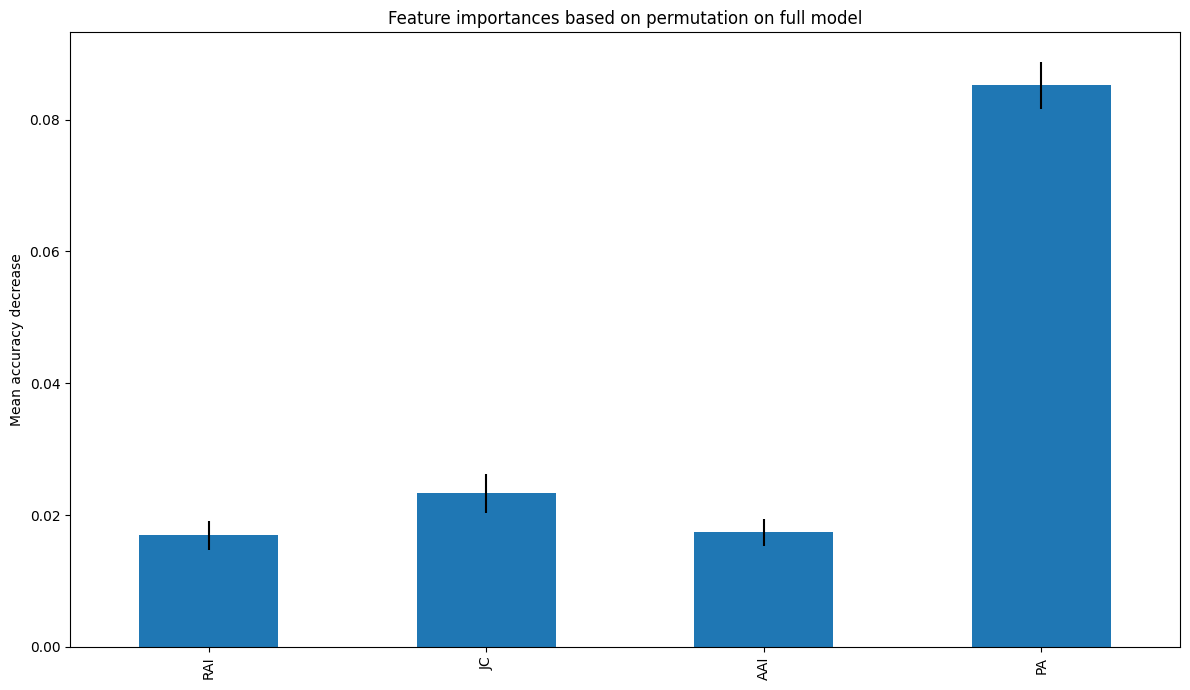

In [15]:
# random forest feature importance based on feature permutation

from sklearn.inspection import permutation_importance

result = permutation_importance(forest, link_prediction_test[feature_names],  link_prediction_test['goal'], n_repeats=10, random_state=seed, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
print('Feature importance based on mean accuracy decrease\n')
print(forest_importances.to_markdown())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances based on permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Step 4
## Quality class analisys

In [16]:
from bisect import bisect

def quality_class_label(error): 
    return bisect(quality_class_intervals, error) - 1

In [17]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba['quality_label'] = link_proba.apply(lambda row: quality_class_label(row['abs_error']), axis=1)
link_proba['quality_name'] = link_proba.apply(lambda row: quality_class_names[quality_class_label(row['abs_error'])], axis=1)
link_proba.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob,abs_error,quality_label,quality_name
0,220,9907,0,0.0,0.0,0.0,0.028138,0.369030,0.369030,1,good
1,1794,2350,0,0.0,0.0,0.0,0.006664,0.463230,0.463230,1,good
2,5331,9086,0,0.0,0.0,0.0,0.004443,0.340661,0.340661,1,good
3,259,4101,0,0.0,0.0,0.0,0.028508,0.210503,0.210503,0,exelent
4,4730,6432,0,0.0,0.0,0.0,0.007775,0.365375,0.365375,1,good


In [18]:
# statistics on error
link_proba['abs_error'].describe()

count    6944.000000
mean        0.373601
std         0.223346
min         0.000000
25%         0.210503
50%         0.378937
75%         0.522519
max         1.000000
Name: abs_error, dtype: float64

Text(0, 0.5, 'Number of node pairs')

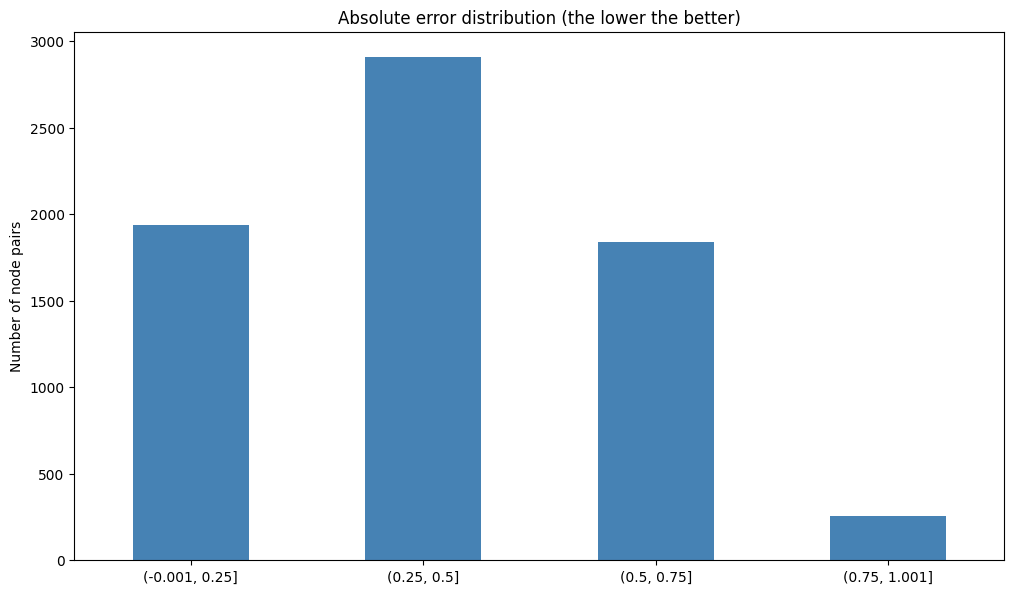

In [19]:
# plot error distribution
fig, ax = plt.subplots()

pd.cut(link_proba['abs_error'], bins=quality_class_intervals, include_lowest=True).value_counts(sort=False).plot.bar(rot=0, color='steelblue', ax=ax)
#ax.set_xticks(np.add(quality_class_labels, 0))
#ax.set_xticklabels(quality_class_names)
ax.set_title("Absolute error distribution (the lower the better)")
ax.set_ylabel("Number of node pairs")

# Step 5
## Quality class prediction

In [20]:
# train for quality class prediction

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=seed, class_weight='balanced')
clf.fit(link_proba[feature_names], link_proba['quality_label'])

LogisticRegression(class_weight='balanced', random_state=889)

In [21]:
# testing the classifier

proba = forest.predict_proba(classifier_test[feature_names])[:, 1]
proba = pd.Series(proba, name='prob')

classifier_test = classifier_test.join(prob)
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: quality_class_label(row['true_abs_error']), axis=1)
classifier_test.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob,true_abs_error,true_quality_label
0,4548,5335,0,0.0,0.0,0.0,0.002221,0.369030,0.369030,1
1,2055,8090,0,0.0,0.0,0.0,0.008886,0.463230,0.463230,1
2,1895,6980,0,0.0,0.0,0.0,0.005183,0.340661,0.340661,1
3,3407,5145,0,0.0,0.0,0.0,0.011107,0.210503,0.210503,0
4,18,7489,0,0.0,0.0,0.0,0.006664,0.365375,0.365375,1


In [22]:
score = clf.score(classifier_test[feature_names], classifier_test['true_quality_label'])
print(f'Accuracy score on {len(classifier_test)} test samples is {score}')

Accuracy score on 6944 test samples is 0.43951612903225806


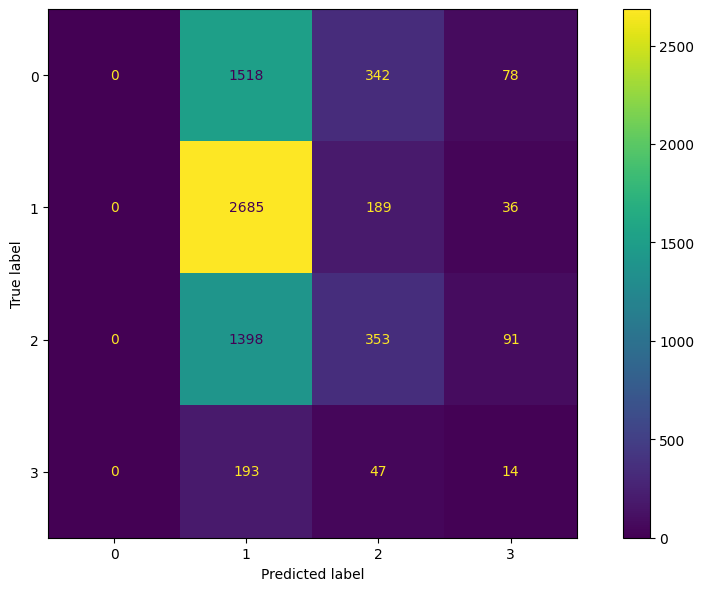

In [23]:
from sklearn import metrics

metrics.plot_confusion_matrix(clf, classifier_test[feature_names], classifier_test['true_quality_label'])